**Прогнозирование заказов такси**

**Постановка задачи**

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Содержание**

1.  Подготовка данных
-  Загрузка необходимых библиотек и датасета
-  Вывод по разделу
2.  Анализ данных
-  Визуализация скользящего среднего
-  Определение тренда и сезонности в данных
-  Выводы по разделу
3.  Обучение
-  Формирование обучающих признаков
-  Разбиение на обучающую и тестовую выборки, удаление пропусков
-  Отделение обучающих и целевого признаков от датасета
-  Обучение и валидация модели DecisionTree
-  Обучение модели LinearRegression
-  Подбор гиперпараметров модели RandomForest
-  Подбор гиперпараметров модели LightGBM
-  Подбор гиперпараметров CatboostRegressor
-  Вывод по разделу
4.  Тестирование
-  Решающее древо
-  Линейная регрессия
-  Случайный лес
-  LightGBM
-  CatboostRegressor
-  Итоговая таблица
-  Вывод по разделу
5.  Вывод по работе

# Подготовка данных

## Загрузка необходимых библиотек и датасета

In [1]:
# Сначала подгружаем необходимые библиотеки и инструменты для дальнейшей обработки данных

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import timeit

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

from datetime import datetime, time

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
# В целях дополнительного эксперимента засечем общее время выполнения тетрадки

start_time_full = datetime.now()

In [3]:
# Теперь загрузим датасет и проведем его визуальный осмотр

df = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])

df.sort_index(inplace=True)

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Проверим монотонность наших данных

print(df.index.is_monotonic)

True


In [5]:
# Для оценки датасета вызовем метод info()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Итого, наш датасет состоит из 26496 объектов (строк) и всего 2 признаков:
    
- datetime - дата и время заказа такси, выступает в качестве индекса, пропусков нет;
- num_orders - количество заказов такси на определенный момент времени, пропусков нет.

In [6]:
# Для некоторого "облегчения" датасета проведем ресемплирование по часу 
# и проведем визуальный осмотр результата 

df_resampled = df.resample('1H').sum()

df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Вывод по разделу

В ходе данного этапа работы были осуществлены действия по загрузке необходимых библиотек и инструментов для дальнейшего анализа данных, сохранен в отдельную переменную исходный датасет, проведен его визуальный осмотр и проверка на монотонность, описание и ресемплирование по одному часу. 
    
Можно двигаться дальше!

# Анализ данных

## Визуализация скользящего среднего

In [7]:
# Для "сглаживания" нашего временного ряда и получения представления о характере изменения количества заказов от времени,
# применим расчет скользящего среднего

df_resampled_roll = df_resampled.rolling(30).mean().dropna()

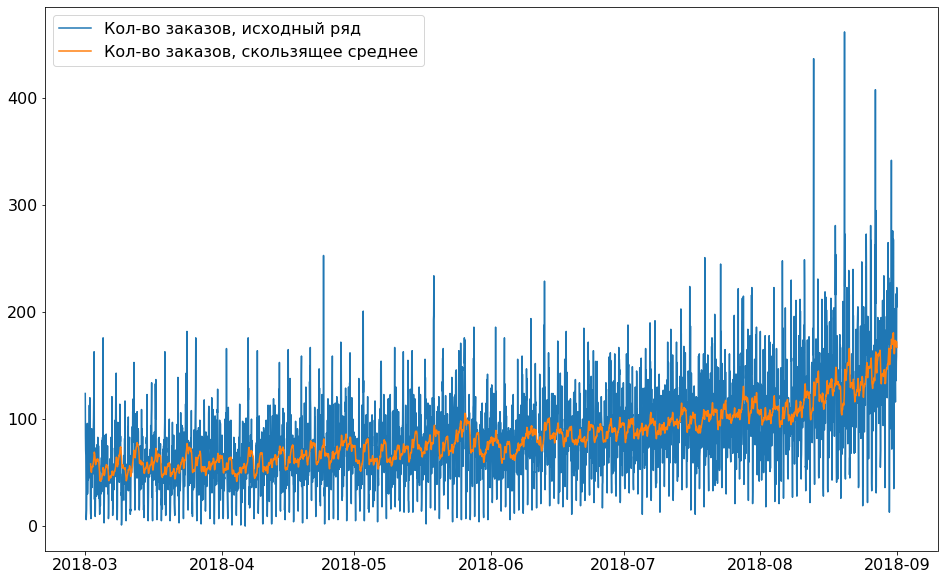

In [8]:
# Для визуализации результата построим графики исходного ряда и скользящего среднего в одном окне

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.plot(df_resampled, label='Кол-во заказов, исходный ряд')

plt.plot(df_resampled_roll, label='Кол-во заказов, скользящее среднее')

plt.legend()
plt.show()

График скользящего среднего значения значительно упрощает визуальную оценку имеющейся функции. Так, на изображении отчетливо видно, что за 7 месяцев  2018 года среднее значение количества заказов постепенно растет. Это может объясняться как истинным ростом, так и сезонным явлением. Для более точного анализа долгосрочной статистики нужно больше данных.

## Определение тренда и сезонности в данных

In [9]:
# Для начала осуществим декомпозицию по всем данным датасета для определения его тренда

decomposed_resampled = seasonal_decompose(df.resample('1D').sum())

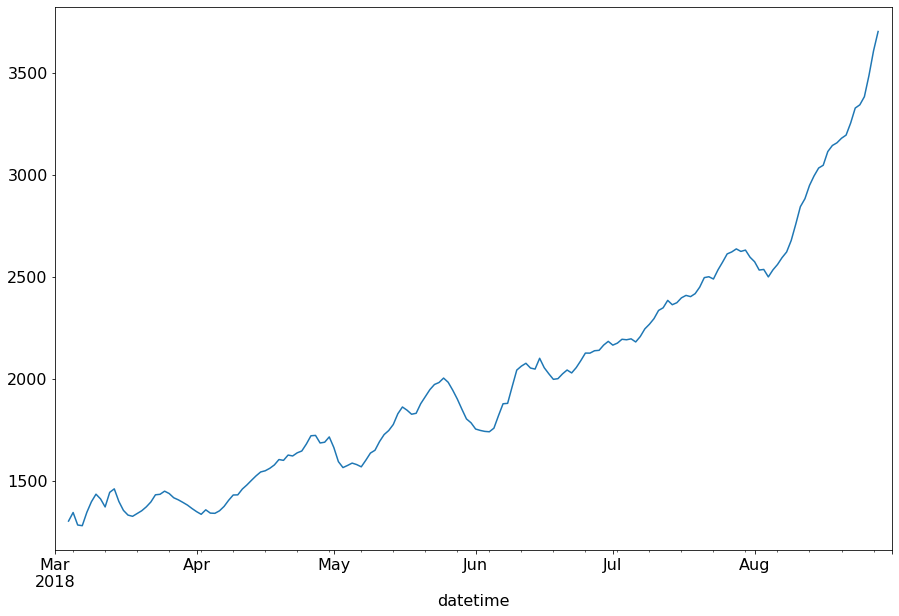

In [10]:
# Выводим результат на графике

decomposed_resampled.trend.plot(figsize=(15,10))
plt.show()

Внешний вид графика тренда в данных подтверждает умозаключения, сделанные по кривой скользящего среднего значения. Количество заказов из месяца в месяц имеет склонность к росту. Осталось только определить, не сезонное ли это явление... но для этого нужно больше данных.

In [11]:
# Данных в датасете достаточно много. Это не даст нормально визуализировать график сезонности количества заказов, 
# заливая изображение сплошным рядом линий. Для исправления данной проблемы возьмем выборку данных за неделю и 
# построим график сезонности по ним.

df_resampled_week = df_resampled['2018-03-10 01:00:00':'2018-03-17 01:00:00']

In [12]:
decomposed_week = seasonal_decompose(df_resampled_week)

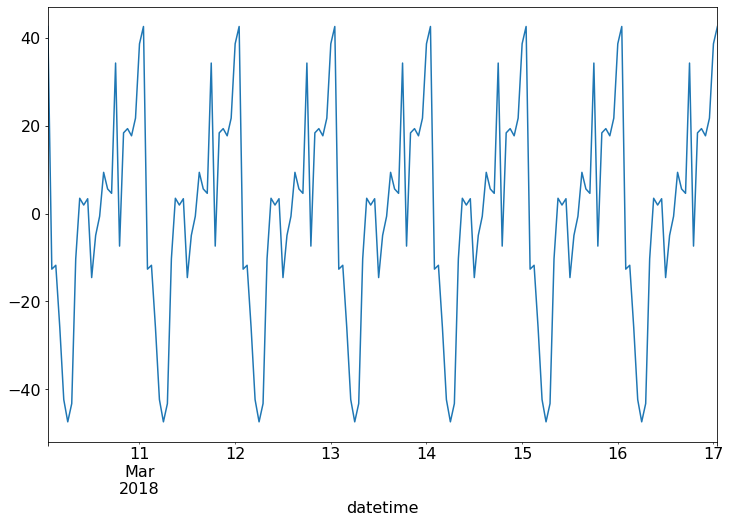

In [13]:
decomposed_week.seasonal.plot(figsize=(12,8))
plt.show()

Сезонность данных достаточно логична. В начале дня (ночь) - большая просадка по заказам, так как большинство людей спит. В течение дня постепенный рост, а пик достигается к вечеру, когда граждане начинают активничать - едут с работы, из гостей/в гости и так далее.

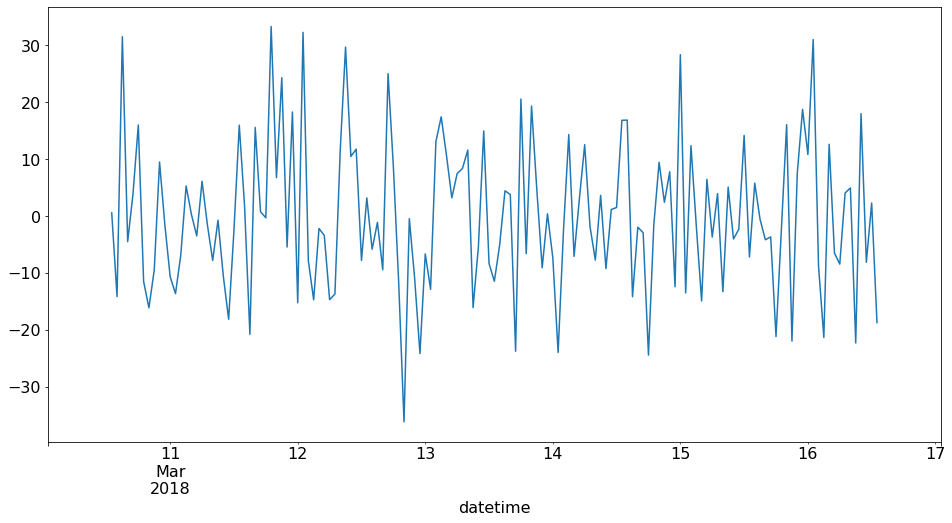

In [14]:
# И, напоследок, построим график "шума", который не относится ни к сезонности, ни к трендовой составляющей декомпозиции данных

decomposed_week.resid.plot(figsize=(16,8))
plt.show()

Ну что здесь сказать - шум он и есть шум. Здесь отображаются совершенно разные факторы, которые могли бы оказать влияние на количество заказов такси. От внезапного ливня, который дает всем намек на возможность добраться домой сухим в машине, до сильных пробок, которые пересаживают людей в метро.

## Выводы по разделу

В данном разделе работы рассчитано скользящее среднее значение, а также была произведена декомпозиция данных на составляющие сезонности, трендовости и "шума".
Данные расчеты показали следующее:
    
- количество пользователей такси со временем растет;
- самым загруженным временем суток для данной сферы является вечер; 
- как и везде в жизни, есть множество факторов, которые влияют на распределение количество заказов, но не носят систематического характера.

# Обучение

## Формирование обучающих признаков

In [15]:
# Сформируем функцию создания признакови из значений месяца, числа и дня недели (год не берем, 
# потому что все данные распределены в 2018 г.)

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(df_resampled, 30, 50)
df_resampled.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Разбиение на обучающую и тестовую выборки, удаление пропусков

In [17]:
# Как и сказано в названии подраздела, разобьем датасет на тренировочную 
# и тестовую выборки в соотношении 9:1. Чтобы порядок ряда сохранился, парамерт shuffle ставим равным False.

df_train, df_test = train_test_split(df_resampled, test_size = 0.1, shuffle = False, random_state = 12345)

In [18]:
# При введении временного лага в признаках у нас появились пропуски в данных. Займемся их жестокой аннигиляцией.
# И сразу смотрим результат.

df_train.dropna(inplace=True)

df_train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,6,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86


In [19]:
# Проводим визуальный осмотр тестовой части

df_test.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,97.0,120.78
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,121.56
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,124.00
2018-08-13 17:00:00,152,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,125.42
2018-08-13 18:00:00,104,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,125.60


In [20]:
# Проверяем корректность разбиения данных на выборки (данные должны быть выстроены по порядку)

print("Тренировочная часть:", df_train.index.min(), df_train.index.max())

print("Тестовая часть:", df_test.index.min(), df_test.index.max())

Тренировочная часть: 2018-03-03 02:00:00 2018-08-13 13:00:00
Тестовая часть: 2018-08-13 14:00:00 2018-08-31 23:00:00


## Отделение обучающих и целевого признаков от датасета

In [21]:
# Ну вы поняли...)))

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders']

## Обучение и валидация модели DecisionTree

In [22]:
features_train.shape

(3924, 33)

In [23]:
features_test.shape

(442, 33)

In [24]:
features_train.shape[0] // (8+1)

436

Для кросс-валидации при использованиии гридсерча будем использовать параметр n_splits, который можно получить из расчета взятой из документации формулы test_size = n_samples // (n_splits + 1) --> 442 = 3924 // (n_splits + 1) --> n_splits ~ 8

In [25]:
%%time

# Начнем с самого простого - обучающего дерева. Для поиска оптимальных параметров используем GridSearch,
# в котором будет применяться специальная кросс-валидация для временных рядов

model_tree = DecisionTreeRegressor()

param_grid = {
    'max_depth': [1,30],
    'min_samples_leaf': [1, 30],
}

tscv = TimeSeriesSplit(n_splits=8) 

gs = GridSearchCV(model_tree, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)


model_tree_fitted = gs.fit(features_train, target_train)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
Wall time: 1.4 s


In [26]:
# Выведем луйший результат метрики и подобранные гиперпараметры модели

rmse_tree_train = (model_tree_fitted.best_score_*(-1))**0.5 
print(rmse_tree_train)
print(model_tree_fitted.best_params_)

28.44049163262637
{'max_depth': 30, 'min_samples_leaf': 30}


## Обучение модели LinearRegression

In [27]:
# Формируем модель линейной регрессии, обучаем ее на тренировочных признаках и получаем предсказания

model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
preds_train = model_LR.predict(features_train)

In [28]:
# Рассчитываем метрику RMSE

mse_LR_train = mean_squared_error(target_train, preds_train)
rmse_LR_train = mse_LR_train**0.5

rmse_LR_train

25.333333632277302

## Подбор гиперпараметров модели RandomForest

In [29]:
%%time
start_time = datetime.now() 

# Подберем оптимальные параметры для обучения случайного леса

model_forest = RandomForestRegressor()

param_grid = {
    'max_depth': [1,20],
    'n_estimators': [1,100],
}

tscv = TimeSeriesSplit(n_splits=8) 
gs = GridSearchCV(model_forest, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

model_forest_fitted = gs.fit(features_train, target_train)

time_forest_GS = datetime.now() - start_time
print(str(time_forest_GS))

Fitting 8 folds for each of 4 candidates, totalling 32 fits
0:00:09.451237
Wall time: 9.45 s


In [30]:
# Выведем луйший результат метрики и подобранные гиперпараметры модели

rmse_forest_train = (model_forest_fitted.best_score_*(-1))**0.5 
print(rmse_forest_train)
print(model_forest_fitted.best_params_)

24.799574328179066
{'max_depth': 20, 'n_estimators': 100}


## Подбор гиперпараметров модели LightGBM

In [31]:
%%time

# Теперь подключим к работе модель градиентного бустинга

train_dataset = lgb.Dataset(features_train, label=target_train)
test_dataset = lgb.Dataset(features_test, label=target_test)

parameters = {'max_depth': np.arange(10, 15),
              'n_estimators': np.arange(45, 50)
             }


tscv = TimeSeriesSplit(n_splits=8) 
gs = GridSearchCV(lgb.LGBMRegressor(random_state=12345), 
                  param_grid=param_grid, 
                  scoring='neg_mean_squared_error', 
                  n_jobs=-1, 
                  cv=tscv, 
                  verbose=1)

# обучение
gs.fit(features_train, target_train)
# просмотр лучших параметров
gs.best_params_

Fitting 8 folds for each of 4 candidates, totalling 32 fits
Wall time: 530 ms


{'max_depth': 20, 'n_estimators': 100}

In [32]:
# Посмотрим на метрику RMSE при полученных гиперпараметрах модели

rmse_lightgbm_train = ((gs.best_score_)*-1)**0.5
print('Метрика RMSE модели LightGBM: {:.2f}'.format(rmse_lightgbm_train))

Метрика RMSE модели LightGBM: 24.68


## Подбор гиперпараметров CatboostRegressor

In [33]:
%%time
# Создадим и обучим модель CatBoost

cbr = CatBoostRegressor(iterations=300,  
                        random_state=12345,  
                        loss_function='RMSE')

cbr.fit(features_train, target_train,  verbose=30)
preds_train = cbr.predict(features_train)

Learning rate set to 0.135235
0:	learn: 36.4170358	total: 152ms	remaining: 45.4s
30:	learn: 22.3611678	total: 225ms	remaining: 1.95s
60:	learn: 20.2114197	total: 296ms	remaining: 1.16s
90:	learn: 18.6263928	total: 367ms	remaining: 842ms
120:	learn: 17.4070792	total: 438ms	remaining: 648ms
150:	learn: 16.2251728	total: 513ms	remaining: 506ms
180:	learn: 15.2695888	total: 586ms	remaining: 385ms
210:	learn: 14.4218711	total: 658ms	remaining: 278ms
240:	learn: 13.6030954	total: 734ms	remaining: 180ms
270:	learn: 12.8809455	total: 808ms	remaining: 86.5ms
299:	learn: 12.1957766	total: 879ms	remaining: 0us
Wall time: 938 ms


In [34]:
# Рассчитаем RMSE для данной модели

mse_catboost_train = mean_squared_error(target_train, preds_train)
rmse_catboost_train = mse_catboost_train ** 0.5
rmse_catboost_train

12.195776597783068

## Вывод по разделу

На данном этапе проекта были совершены следующие операции:
    
- сформированы обучающие признаки с помощью смещения признаков по временной оси;
- данные разбиты на обучающую и тестовую выборки, удалены появившиеся при смещении пропуски;
- выборки разбиты на обучающие и целевой признаки;
- обучены разнообразные модели машинного обучения, посчитаны их метрики RMSE на обучающей выборке.

# Тестирование

## Решающее древо

In [35]:
%%time

# Дадим решающему дереву с GS-параметрами проявить себя в предасказаниях! Обучаем модель.

tree = DecisionTreeRegressor(max_depth = model_tree_fitted.best_params_['max_depth'],
                             min_samples_leaf=model_tree_fitted.best_params_['min_samples_leaf'], random_state=12345)

tree.fit(features_train, target_train)

Wall time: 44.2 ms


DecisionTreeRegressor(max_depth=30, min_samples_leaf=30, random_state=12345)

In [36]:
%%time

# Делаем предсказания и рассчитываем метрику RMSE

predicts = tree.predict(features_test)

time_tree_test = datetime.now() - start_time

rmse_tree_test = mean_squared_error(target_test, predicts)**0.5
print('RMSE_DecisionTreeRegressor: {:.2f}'.format(rmse_tree_test))

RMSE_DecisionTreeRegressor: 56.34
Wall time: 1 ms


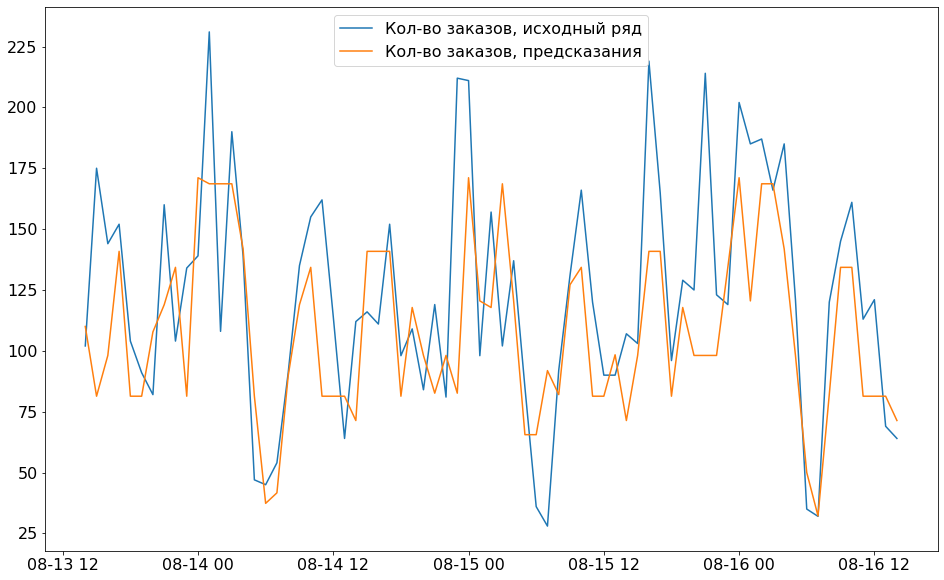

In [37]:
plt.plot(target_test['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, исходный ряд')
plt.plot(pd.DataFrame(data=predicts, index = target_test.index)['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, предсказания')

plt.legend()
plt.show()

## Линейная регрессия

In [38]:
%%time

# Посчитаем предсказания с помощью линечной регрессии и найдем RMSE

preds_test = model_LR.predict(features_test)

mse_LR_test = mean_squared_error(preds_test, target_test)
rmse_LR_test = mse_LR_test**0.5

rmse_LR_test

Wall time: 1 ms


44.63845557357861

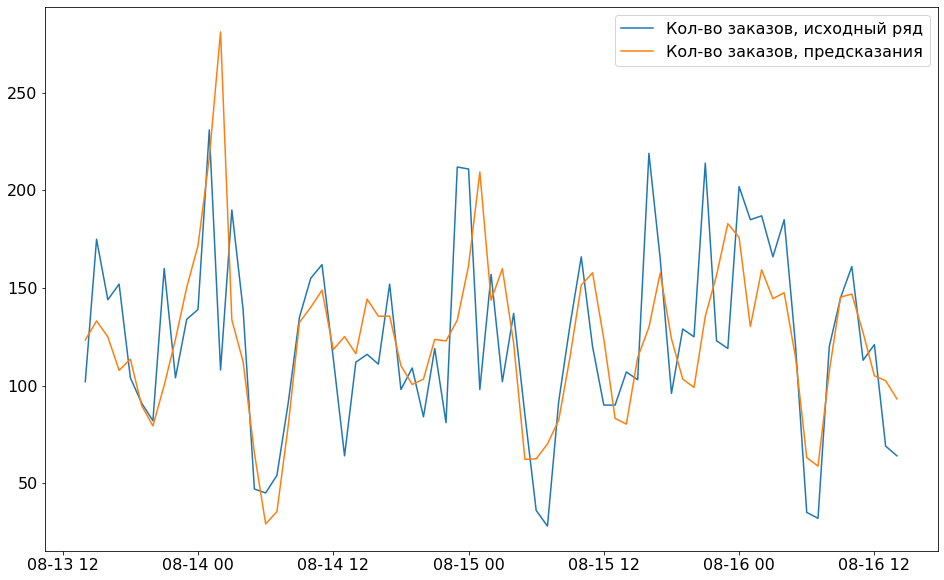

In [39]:
plt.plot(target_test['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, исходный ряд')
plt.plot(pd.DataFrame(data=preds_test, index = target_test.index)['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, предсказания')

plt.legend()
plt.show()

## Случайный лес

In [40]:
%%time

# На этом этапе обучаем случайны лес с подобранными ранее гиперпараметрами

forest = RandomForestRegressor(random_state = 12345, n_estimators = model_forest_fitted .best_params_['n_estimators'], 
                               max_depth = model_forest_fitted .best_params_['max_depth'])

forest.fit(features_train, target_train)

Wall time: 4.73 s


RandomForestRegressor(max_depth=20, random_state=12345)

In [41]:
%%time

# Запускаем полученную модель на предсказания и  считаем RMSE для результатов модели

predicts = forest.predict(features_test)
rmse_forest_test = mean_squared_error(target_test, predicts)**0.5

print('RMSE_RandomForest: {}'.format(rmse_forest_test))

RMSE_RandomForest: 45.07350459864079
Wall time: 12 ms


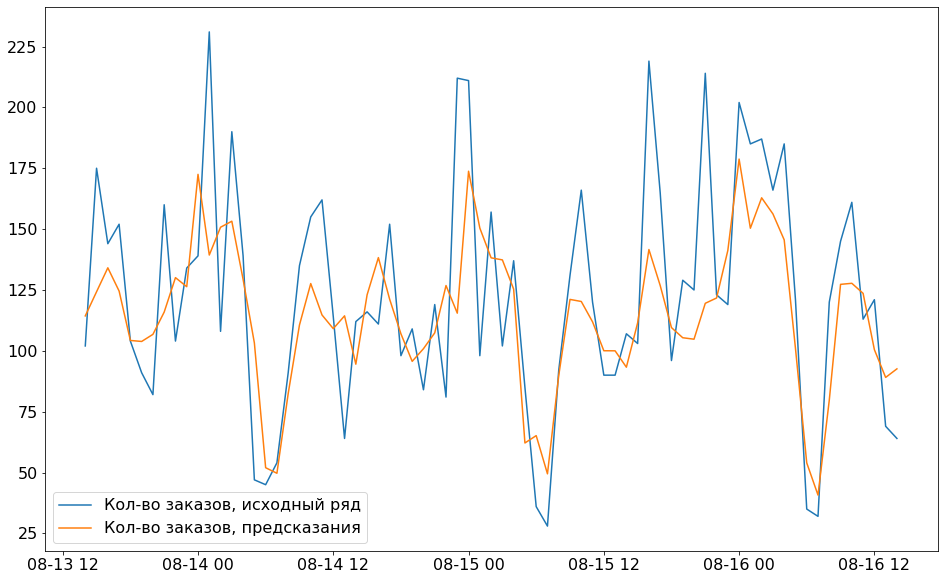

In [42]:
plt.plot(target_test['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, исходный ряд')
plt.plot(pd.DataFrame(data=predicts, index = target_test.index)['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, предсказания')

plt.legend()
plt.show()

## LightGBM

In [43]:
%%time

# Обучаем модель градиентного бустинга

model_lgb = (lgb.LGBMRegressor(max_depth=gs.best_params_['max_depth'], 
                           n_estimators=gs.best_params_['n_estimators'],
                           random_state=12345)
             .fit(features_train, target_train)
            )

Wall time: 90.6 ms


In [44]:
%time 

# Делаем предсказания и считаем RMSE

predictions_test = model_lgb.predict(features_test)

mse_lightGBM_test = mean_squared_error(target_test, predictions_test)
rmse_lightGBM_test = mse_lightGBM_test ** 0.5
print('RMSE_lightGBM: {}'.format(rmse_lightGBM_test))

Wall time: 0 ns
RMSE_lightGBM: 41.70359155557893


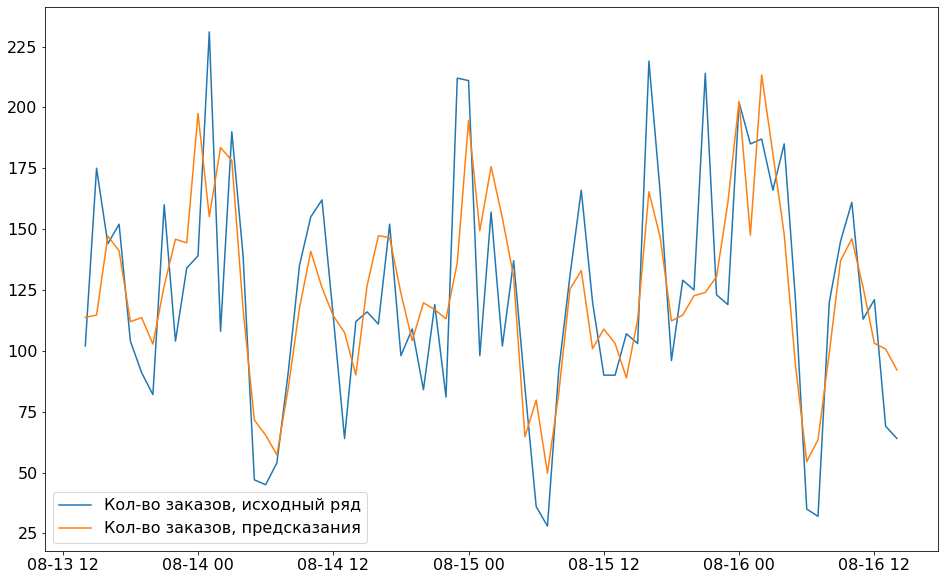

In [45]:
plt.plot(target_test['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, исходный ряд')
plt.plot(pd.DataFrame(data=predictions_test, index = target_test.index)['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, предсказания')

plt.legend()
plt.show()

## CatboostRegressor

In [46]:
%%time

# Делаем предсказания моделью CatBoost  и рассчитываем RMSE

predictions_test = cbr.predict(features_test)

mse_test_catboost = mean_squared_error(target_test, predictions_test)
rmse_test_catboost = mse_test_catboost ** 0.5
rmse_test_catboost
   
print("RMSE_Catboost:", rmse_test_catboost)

RMSE_Catboost: 41.886682956043416
Wall time: 2 ms


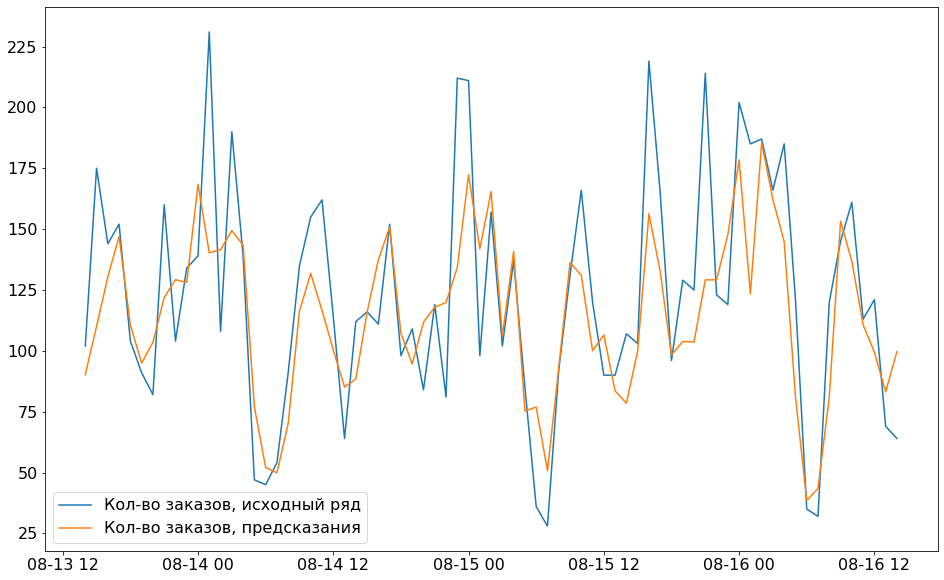

In [47]:
plt.plot(target_test['2018-08-13 14:00:00':'2018-08-16 14:00:00'], label='Кол-во заказов, исходный ряд')
plt.plot(pd.DataFrame(data=predictions_test, index = target_test.index)['2018-08-13 14:00:00':'2018-08-16 14:00:00'], 
                                         label='Кол-во заказов, предсказания')

plt.legend()
plt.show()

## Итоговая таблица

In [48]:
# Сгруппируем результаты в отдельную таблиуцу

table_final = pd.DataFrame({'Модель': ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LightGBM', 'CatBoostRegressor'],

                             'RMSE_train': [rmse_LR_train, rmse_tree_train, rmse_forest_train, rmse_lightgbm_train, rmse_catboost_train],
                            
                           'RMSE_test': [rmse_LR_test, rmse_tree_test, rmse_forest_test, rmse_lightGBM_test, rmse_test_catboost]})

table_final

,Модель,RMSE_train,RMSE_test
0,LinearRegression,25.333334,44.638456
1,DecisionTreeRegressor,28.440492,56.336324
2,RandomForestRegressor,24.799574,45.073505
3,LightGBM,24.682845,41.703592
4,CatBoostRegressor,12.195777,41.886683


## Вывод по разделу

В данной части работы были получены предсказания на тестовых данных для обученных по подобранным гиперпараметрам моделей. Посчитаны RMSE. Выяснено, что почти все модели справились с задачей получения метрики ниже 48 единиц. Не смогла преодолеть такой порог только модель решающего древа.

# Вывод по работе

За время работы с проектом были проделаны следующие операции:
    
- загружены необходимые библиотеки и исходный датасет, данные проверены;
- проведен аналих исходного временного ряда, выявлены трендовые и сезонные показатели, а также "шум";
- сформированы признаки, обучены модели решающего древа, линейной регрессии, случайного леса, LightGBM и CatBoost. Посчитаны метрики RMSE на предсказаниях при использовании тренировочной выборки; 
- проведено тестирование указанных ML моделей. Выяснено, что при правильно подобранных гиперпараметрах, а также при грамотной установке значения временного лага (то есть, количестве полученных смещением обучающиз признаков), можно добиться требуемых параметров метрики RMSE. Лучше всех себя при этом проявил LightGBM, показав результат метрики 41.703592.

In [49]:
# Оценим время расчета всего проекта

time_total = datetime.now() - start_time_full
print('Время выполнения всей тетрадки:', str(time_total))

Время выполнения всей тетрадки: 0:00:19.020236
